# Q Learning CartPole Implementation

## Imports

In [1]:
import gymnasium as gym
import numpy as np 
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import torch

## Environment

The CartPole environment consists of a pole which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. The state space is represented by four values: cart position, cart velocity, pole angle, and the velocity of the tip of the pole. The action space consists of two actions: moving left or moving right. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 

Source: [https://gym.openai.com/envs/CartPole-v1/](Open AI Gym). 

The cell below plots a bunch of example frames from the environment.

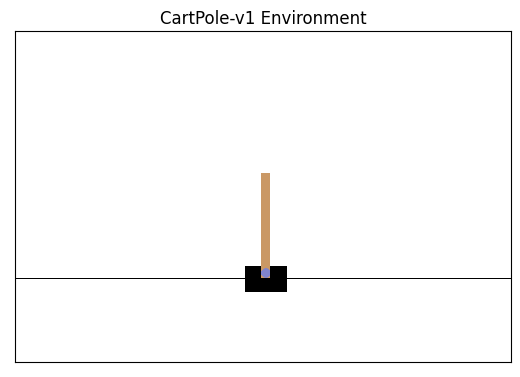

In [2]:
# Demonstration
env = gym.envs.make("CartPole-v1", render_mode="rgb_array")


def get_screen():
    ''' Extract one step of the simulation.'''
    screen = env.render().transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

# Speify the number of simulation steps
num_steps = 100

# Show several steps
for i in range(num_steps):
    clear_output(wait=True)
    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.title('CartPole-v1 Environment')
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Define QTable and QLearning Methods

In [3]:
def Qtable(state_space,action_space,bin_size = 30):
    
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    
    q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    return q_table, bins

def Discrete(state, bins):
    index = []
    for i in range(len(state)): 
        index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)


In [4]:
def Q_learning(q_table, bins, episodes = 5000, gamma = 0.95, lr = 0.1, timestep = 5000, epsilon = 0.2, score_threshold = 195):
    rewards = 0
    solved = False 
    steps = 0 
    runs = [0]
    data = {'max' : [0], 'avg' : [0]}
    start = time.time()
    ep = [i for i in range(0,episodes + 1,timestep)] 
    
    for episode in range(1,episodes+1):
        
        current_state = Discrete(env.reset()[0],bins) # initial observation
        score = 0
        done = False
        temp_start = time.time()
        
        while not done:
            steps += 1 
            ep_start = time.time()
            if episode%timestep == 0:
                env.render()
                
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])
            
            observation, reward, done, info, _ = env.step(action)
            next_state = Discrete(observation,bins)

            score += reward
            

            if not done:
                max_future_q = np.max(q_table[next_state])
                current_q = q_table[current_state+(action,)]
                new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                q_table[current_state+(action,)] = new_q

            current_state = next_state
            
        # End of the loop update
        else:
            rewards += score
            runs.append(score)
            if score > score_threshold and steps >= 100 and solved == False: # considered as a solved:
                solved = True
                print('Solved in episode : {} in time {}'.format(episode, (time.time()-ep_start)))
        
        # Timestep value update
        if episode%timestep == 0:
            print('Episode : {} | Reward -> {} | Max reward : {} | Time : {}'.format(episode,rewards/timestep, max(runs), time.time() - ep_start))
            data['max'].append(max(runs))
            data['avg'].append(rewards/timestep)
            if rewards/timestep >= score_threshold: 
                print('Solved in episode : {}'.format(episode))
            rewards, runs= 0, [0] 
            
    if len(ep) == len(data['max']):
        plt.plot(ep, data['max'], label = 'Max')
        plt.plot(ep, data['avg'], label = 'Avg')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc = "upper left")
        
    env.close()

## Make CartPole Env

In [5]:
# CART POLE
env = gym.make('CartPole-v1', render_mode="rgb_array")
print(env.observation_space.low,"\n",env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] 
 [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


## Train on CartPole

Solved in episode : 510 in time 3.504753112792969e-05
Episode : 1000 | Reward -> 74.294 | Max reward : 326.0 | Time : 0.0012118816375732422
Episode : 2000 | Reward -> 129.313 | Max reward : 682.0 | Time : 0.0012001991271972656
Episode : 3000 | Reward -> 137.531 | Max reward : 470.0 | Time : 0.00119781494140625
Episode : 4000 | Reward -> 147.72 | Max reward : 472.0 | Time : 0.0012059211730957031
Episode : 5000 | Reward -> 167.002 | Max reward : 834.0 | Time : 0.0012369155883789062
Episode : 1000 | Reward -> 64.336 | Max reward : 207.0 | Time : 0.001196146011352539
Solved in episode : 1347 in time 3.0994415283203125e-05
Episode : 2000 | Reward -> 104.9 | Max reward : 444.0 | Time : 0.0012459754943847656
Episode : 3000 | Reward -> 134.127 | Max reward : 567.0 | Time : 0.0012021064758300781
Episode : 4000 | Reward -> 135.708 | Max reward : 459.0 | Time : 0.0012199878692626953
Episode : 5000 | Reward -> 145.042 | Max reward : 706.0 | Time : 0.0011942386627197266
Episode : 6000 | Reward -> 1

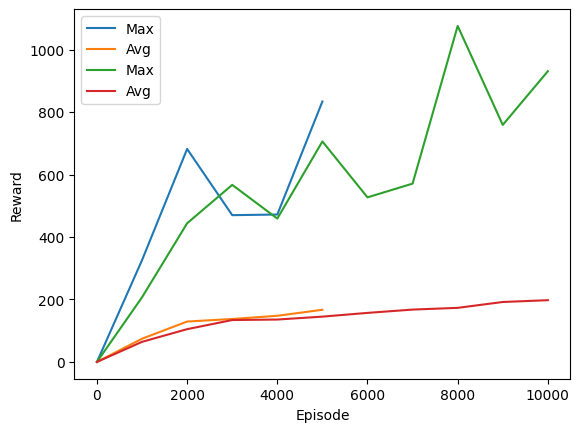

In [6]:
# TRANING
q_table, bins = Qtable(len(env.observation_space.low), env.action_space.n)
Q_learning(q_table, bins, lr = 0.15, gamma = 0.995, episodes = 5*10**3, timestep = 1000)

q_table, bins = Qtable(len(env.observation_space.low), env.action_space.n)
Q_learning(q_table, bins, lr = 0.15, gamma = 0.995, episodes = 1*10**4, timestep = 1000, score_threshold = 250)